In [2]:

import os
import glob
import sys
sys.path.insert(0,'../model_code')
from BF_main import read_data_and_configs, run_beamformer, run_image_processing, pre_process_configs, precompute_geometry
from PIL import Image
import numpy as np
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import mplcursors
challenge_set = ['L7-4_General']

dir = challenge_set[0]

data_dir = f'../Challenge_sets/{dir}'
config_dir = os.path.join(data_dir, 'presets/scratch')
raw_rf_dir = os.path.join(data_dir, 'data')
raw_rf_files = glob.glob(os.path.join(raw_rf_dir, '*_raw_rf.npy'))
cine_files = glob.glob(os.path.join(raw_rf_dir, '*_cine.npy'))
image_files = glob.glob(os.path.join(raw_rf_dir, '*.png'))
#use first file
#raw_rf_path = os.path.join(raw_rf_dir, Files[0])
mode = 0
rf_data, preset = read_data_and_configs(raw_rf_dir, config_dir, mode)
xdc, field, param = pre_process_configs(preset,mode)
recon = precompute_geometry(xdc, field, param)
recon_image = run_beamformer(rf_data, xdc, field, param, recon)

ModuleNotFoundError: No module named 'BF_main'

original cine size (128, 2597)
ref_model size (128, 2597)
*****
cine
min -8899.3515625
max 8187.58642578125
reference model
min -17.625664934456573
max 18.306897192056404
*****


1

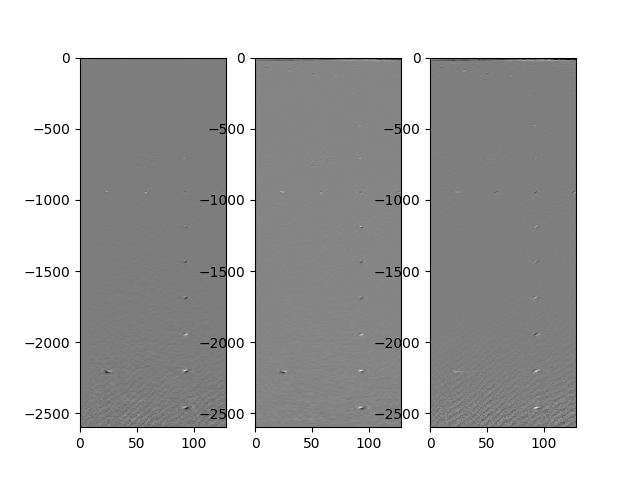

In [2]:
%matplotlib widget 
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.close('all')
# sum data through transmits
#recon_image_sum = np.sum(recon_image, axis=1)
cine = np.load(cine_files[0]).squeeze().transpose()
print("original cine size {}".format(cine.shape))
print("ref_model size {}".format(recon_image.shape))

# reduce recon_image to cine
recon_image = recon_image[:,:cine.shape[1]]

def normalize_data(data):
    data_min = np.min(data.flatten())
    data_max = np.max(data.flatten())
    normalized_data = data/data_max
    return normalized_data

print('*****')
print('cine')
print('min {}'.format(np.min(cine.flatten())))
print('max {}'.format(np.max(cine.flatten())))
print('reference model')
print('min {}'.format(np.min(recon_image.flatten())))
print('max {}'.format(np.max(recon_image.flatten())))
print('*****')

cine_norm = normalize_data(cine)
ref_norm = normalize_data(recon_image)
bf_diff = cine_norm-ref_norm

# plot beamformed datat
from matplotlib.transforms import Affine2D

rotation = Affine2D().rotate_deg(-90)
fig, ax = plt.subplots(1,3)

ax[0].pcolormesh(ref_norm, cmap='grey', transform=rotation + ax[0].transData)
ax[1].pcolormesh(cine_norm, cmap='grey', transform=rotation + ax[1].transData)
ax[2].pcolormesh(bf_diff, cmap='grey', transform=rotation + ax[2].transData)

def update_color_scale(event, axis_list, plot_list): 
    print(event.inaxes)

    if event.inaxes == ax: 
        xlim = ax.get_xlim() 
        ylim = ax.get_ylim() 
        #zoomed_data = data[int(ylim[0]):int(ylim[1]), int(xlim[0]):int(xlim[1])] 
        #cax.set_norm(Normalize(vmin=np.min(zoomed_data), vmax=np.max(zoomed_data))) 
        #fig.canvas.draw_idle()

# Link the axes 
def on_xlim_change(event_ax):
    ax[1].set_xlim(event_ax.get_xlim())
    ax[2].set_xlim(event_ax.get_xlim())
    fig.canvas.draw_idle() 
    
def on_ylim_change(event_ax): 
    ax[1].set_ylim(event_ax.get_ylim())
    ax[2].set_ylim(event_ax.get_ylim())
    fig.canvas.draw_idle() 
    
ax[0].callbacks.connect('xlim_changed', on_xlim_change) 
ax[0].callbacks.connect('ylim_changed', on_ylim_change)
#fig1.canvas.mpl_connect('button_release_event', lambda event: update_color_scale(event, axis_ones, [cax0, cax1]))


8187.5864
-8899.352
threshold: 854.3468627929688
18.306897192056404
-17.625664934456573
threshold: 1.7966281063256488
polarity diff histogram
*******************
Value: 0.0, Count: 332404
Value: 1.0, Count: 12
cine polarity histogram
*******************
Value: 0.0, Count: 330060
Value: 1.0, Count: 1132
Value: -1.0, Count: 1224
ref polarity histogram
*******************
Value: 0.0, Count: 330470
Value: -1.0, Count: 1212
Value: 1.0, Count: 734
cine min / max -8899.3515625/8187.58642578125
ref min / max -17.625664934456573/18.306897192056404
cine_norm min / max -1.0869321823120117/1.0
ref_norm min / max -0.9627882185357207/1.0


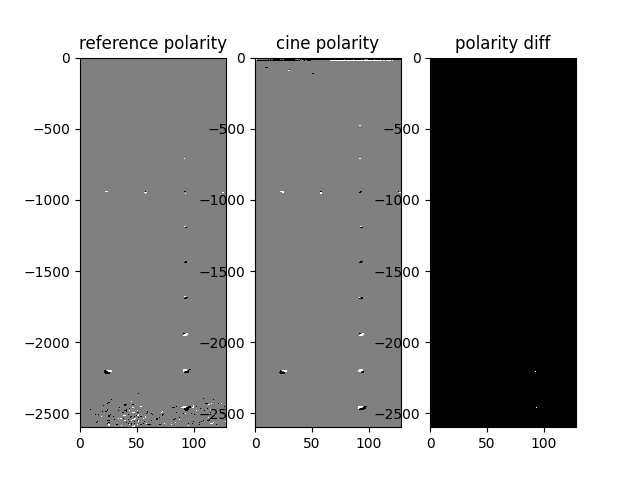

In [3]:
def image_polarity(data, threshold_percent = 5 ):

    print(np.max(data))
    print(np.min(data))
    threshold = threshold_percent*.01*(np.max(data) - np.min(data))
    print(f'threshold: {threshold}')
    
    polarity = np.zeros(data.shape)
    polarity[data > threshold] = 1
    polarity[data < -threshold] = -1
    return polarity

fig1, ax_polarity = plt.subplots(1,3)

cine_polarity = image_polarity(cine)
reference_polarity = image_polarity(recon_image)
polarity_diff = np.zeros(cine_polarity.shape)
polarity_diff[1<np.abs(cine_polarity-reference_polarity)] = 1  

cax0 = ax_polarity[0].pcolormesh(reference_polarity, cmap='grey', transform=rotation + ax_polarity[0].transData)
ax_polarity[0].set_title('reference polarity')
cax1 = ax_polarity[1].pcolormesh(cine_polarity, cmap='grey', transform=rotation + ax_polarity[1].transData)
ax_polarity[1].set_title('cine polarity')
cax2 = ax_polarity[2].pcolormesh(polarity_diff, cmap='grey', transform=rotation + ax_polarity[2].transData)
ax_polarity[2].set_title('polarity diff')
#fig1.colorbar(cax2, ax=ax_polarity[2])

# Function to update the color scale 
def update_color_scale(event, axis_list, plot_list):    
    if event.inaxes == ax: 
        xlim = ax.get_xlim() 
        ylim = ax.get_ylim() 
        #zoomed_data = data[int(ylim[0]):int(ylim[1]), int(xlim[0]):int(xlim[1])] 
        #cax.set_norm(Normalize(vmin=np.min(zoomed_data), vmax=np.max(zoomed_data))) 
        #fig.canvas.draw_idle()

# Link the axes 
def on_xlim_change_polarity(event_ax):
    ax_polarity[1].set_xlim(event_ax.get_xlim())
    ax_polarity[2].set_xlim(event_ax.get_xlim())
    fig1.canvas.draw_idle() 
    
def on_ylim_change_polarity(event_ax): 
    ax_polarity[1].set_ylim(event_ax.get_ylim())
    ax_polarity[2].set_ylim(event_ax.get_ylim())
    fig1.canvas.draw_idle() 
    
ax_polarity[0].callbacks.connect('xlim_changed', on_xlim_change_polarity) 
ax_polarity[0].callbacks.connect('ylim_changed', on_ylim_change_polarity)
#ax_polarity[2].callbacks.connect('xlim_changed', on_xlim_change_polarity) 
#ax_polarity[2].callbacks.connect('ylim_changed', on_ylim_change_polarity)


fig1.canvas.mpl_connect('button_release_event', lambda event: update_color_scale(event, ax_polarity, [cax0, cax1]))

from collections import Counter

print('polarity diff histogram')
print('*******************')

histogram = Counter(list(polarity_diff.flatten()))
for value, count in histogram.items(): 
    print(f"Value: {value}, Count: {count}")

print('cine polarity histogram')
print('*******************')
histogram = Counter(list(cine_polarity.flatten()))
for value, count in histogram.items(): 
    print(f"Value: {value}, Count: {count}")

print('ref polarity histogram')
print('*******************')
histogram = Counter(list(reference_polarity.flatten()))
for value, count in histogram.items(): 
    print(f"Value: {value}, Count: {count}")

# where does the polarity match?
cine_min = np.min(cine.flatten())
cine_max = np.max(cine.flatten())
ref_min = np.min(recon_image.flatten())
ref_max = np.max(recon_image.flatten())

print('cine min / max {}/{}'.format(cine_min, cine_max))
print('ref min / max {}/{}'.format(ref_min, ref_max))

cine_norm_min = np.min(cine_norm.flatten())
cine_norm_max = np.max(cine_norm.flatten())
ref_norm_min = np.min(ref_norm.flatten())
ref_norm_max = np.max(ref_norm.flatten())
print('cine_norm min / max {}/{}'.format(cine_norm_min, cine_norm_max))
print('ref_norm min / max {}/{}'.format(ref_norm_min, ref_norm_max))

#normalized_diff = cine_norm-ref_norm
#fig, axes = plt.subplots(1,2)
#axes[0].pcolormesh(normalized_diff, cmap='grey', transform=rotation + axes[0].transData)
#axes[1].hist(normalized_diff.flatten(), bins=1000)

Text(0.5, 1.0, 'histogram of normalized data')

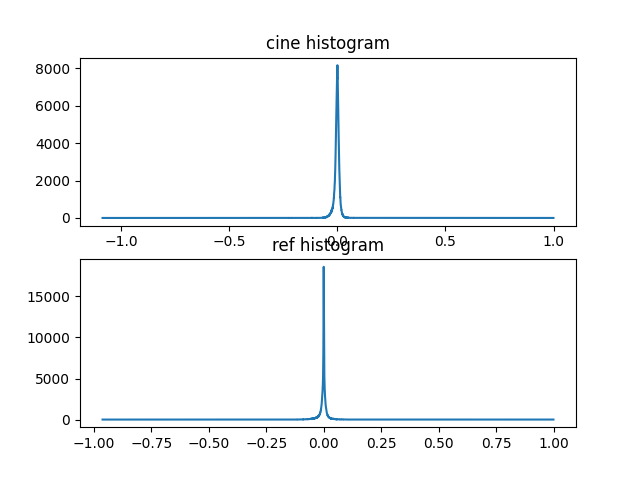

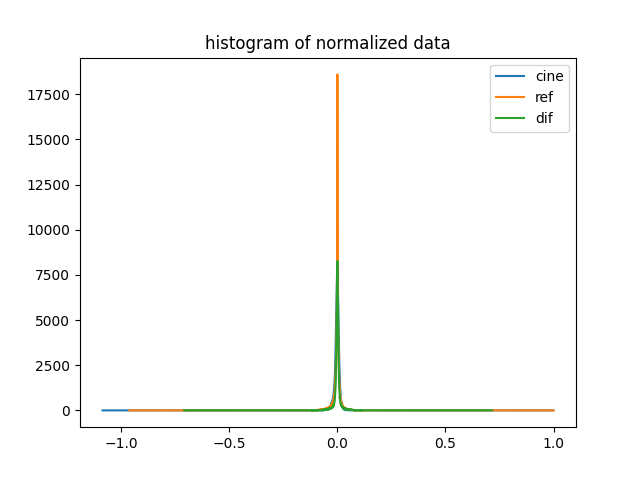

In [8]:
# compare histograms of both data
fig, ax = plt.subplots(2,1)
fig2, ax2 = plt.subplots()

cine_hist, cine_bin_edges = np.histogram(cine_norm.flatten(), bins=5000)
ref_hist, ref_bin_edges = np.histogram(ref_norm.flatten(), bins=5000)
diff_hist, diff_bin_edges = np.histogram(bf_diff.flatten(), bins=5000)

ax[0].plot(cine_bin_edges[:-1],cine_hist)
ax[0].set_title('cine histogram')
ax[1].plot(ref_bin_edges[:-1], ref_hist)
ax[1].set_title('ref histogram')
ax2.plot(cine_bin_edges[:-1], cine_hist, label = 'cine')
ax2.plot(ref_bin_edges[:-1], ref_hist, label = 'ref')
ax2.plot(diff_bin_edges[:-1], diff_hist, label = 'dif')
ax2.legend()
ax2.set_title('histogram of normalized data')

In [ ]:
cine_zeros = np.zeros(cine_polarity.shape)
cine_zeros[cine == 0] = 1

fig, ax_cine_zeros = plt.subplots()
c = ax_cine_zeros.pcolormesh(cine_zeros, cmap='grey', transform=rotation + ax_cine_zeros.transData)
fig.colorbar(c, ax=ax_cine_zeros)
ax_cine_zeros.set_ylim(-40, 0)
ax_cine_zeros.set_xlim(0, 120)
ax_cine_zeros.set_title('cine zeros')

In [ ]:
#plot limiiters sizes

#fig, ax_limiters = plt.subplots(1,2)
print(recon.keys())
print(recon['tx_limiter'].shape)



In [ ]:
num_samples = rf_data.shape[1]
scale = 9
print(raw_rf_files[0])
title = raw_rf_files[0].split('\\')[-1].split('.')[0]
fig, ax = plt.subplots(1,2)
image = Image.open(image_files[0])
print(image_files[0])
image_array = np.array(image)
if xdc['type'] == 0:
    image_array = image_array[41:839, 442:740, :]  # grab image from display
else:
    image_array = image_array[183:700, 230:950, :] #curvilinear image splice
ax[1].imshow(image_array)
ax[1].set_title('dstMain')
print()
title = raw_rf_files[0].split('_raw_rf.')[0].split('\\')[-1]

recon_image_sum = np.sum(recon_image, axis=1) / 2 ** 15

run_image_processing(recon_image_sum, xdc, field, param, num_samples, title = title, ax=ax[0])

